# PANORAMA STITCHING

## Step 0: Set the environment and define functions

In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim

## Step 1: Load images

In [2]:
# Function to read images from a folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

## Step 2: Extract and Match Features

In [3]:
def extract_and_match_features(left_img, right_img, method='SURF', display_matches=False):
    if method == 'SURF':
        feature_extractor = cv2.xfeatures2d.SURF_create()
    elif method == 'ORB':
        feature_extractor = cv2.ORB_create()
    else:
        raise ValueError("Method must be 'SURF' or 'ORB'")

    # Find the keypoints and descriptors
    kp1, des1 = feature_extractor.detectAndCompute(left_img, None)
    kp2, des2 = feature_extractor.detectAndCompute(right_img, None)
    
    if des1 is None or des2 is None:
        print(f"No descriptors found in one or both images using {method}.")
        return []

    # Use FLANN or brute-force matcher depending on method
    if method == 'SURF':
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(des1, des2, k=2)
    elif method == 'ORB':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = bf.match(des1, des2)

    good_matches = []
    if method == 'SURF':
        for m, n in matches:
            if m.distance < 0.3 * n.distance:
                good_matches.append(m)
    elif method == 'ORB':
        good_matches = sorted(matches, key=lambda x: x.distance)

    # Visualize matches if requested
    if display_matches:
        match_img = cv2.drawMatches(left_img, kp1, right_img, kp2, good_matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        cv2.imshow(f"Matches - {method}", match_img)
        cv2.waitKey(0)  # Wait for key press to close

    left_points = np.array([kp1[m.queryIdx].pt for m in good_matches])
    right_points = np.array([kp2[m.trainIdx].pt for m in good_matches])

    try:
        matched_points = np.concatenate((left_points, right_points), axis=1)
    except ValueError:
        return []
    
    return matched_points


## Step 3: Finding Homography with RANSAC

In [4]:
# Homography matrix calculation
def homography(matches):
    temp_matrix = []

    for i in range(len(matches)):

        x1 = matches[i][0] 
        y1 = matches[i][1] 

        x2 = matches[i][2] 
        y2 = matches[i][3]

        # Create a matrix with the coordinates
        temp_matrix.append([x1, y1, 1, 0, 0, 0, -x1 * x2, -x2 * y1, -x2])
        temp_matrix.append([0, 0, 0, x1, y1, 1, -y2 * x1, -y2 * y1, -y2])

    # Perform SVD
    temp_matrix = np.reshape(temp_matrix, (-1, 9))
    u, s, vh = np.linalg.svd(temp_matrix)
    vh = vh[len(vh)-1].reshape(3, 3)
    homography_matrix = vh / vh[2, 2]

    return homography_matrix

# RANSAC method to calculate homography
def ransac(matches, threshold = 0.3, max_iter = 1000):
    if len(matches) < 4:
        return [], None
    
    inl = []
    for i in range(max_iter): 
        best_pairs = matches[np.random.choice(len(matches), 4, False)]
        h = homography(best_pairs)

        source = np.array([np.append(matches[i][:2], 1) for i in range(len(matches))]).T
        destination = matches[:, 2: 4]
        
        temp = np.array([row / row[2] for row in (np.dot(h, source)).T])[:, :2]
        err = np.linalg.norm(destination - temp, axis=1) ** 2

        # Calculate the inliers
        location = np.where(err < threshold)[0]
        i = matches[location]

        # Update the inliers
        if len(i) > len(inl):
            inl = i
            histogram = h

    return inl, histogram

## Step 4: Constructing Panoramas

In [5]:
# Warping the images using the homography matrix
def warp_perspective(src, M, dsize):
    
    M_inv = np.linalg.inv(M)
    x_coords, y_coords = np.meshgrid(np.arange(dsize[0]), np.arange(dsize[1]))
    homog_coords = np.stack([x_coords, y_coords, np.ones_like(x_coords)], axis=-1)

    # Apply the inverse matrix to each coordinate
    src_coords = (M_inv @ homog_coords.reshape(-1, 3).T).T
    src_coords = src_coords[:, :2] / src_coords[:, [2]]
    src_coords = np.round(src_coords).astype(int)

    # Create the output image
    dst = np.zeros((dsize[1], dsize[0], src.shape[2]), dtype=src.dtype)

    # Copy valid pixels from source to destination
    valid = ((src_coords[:, 0] >= 0) & (src_coords[:, 0] < src.shape[1]) &
             (src_coords[:, 1] >= 0) & (src_coords[:, 1] < src.shape[0]))
    src_coords = src_coords[valid]
    
    dst_coords = np.column_stack(np.where(valid.reshape(dsize[1], dsize[0])))
    dst[dst_coords[:, 0], dst_coords[:, 1]] = src[src_coords[:, 1], src_coords[:, 0]]

    return dst

# Stitching the images together with warping the left image and then the right image
def stitch_images(left_image, right_image, homograph):
    # Check if homograph is valid before proceeding
    if homograph is None:
        print("Skipping stitching due to insufficient or invalid homography matrix.")
        return left_image  # Return the left image if homography is invalid
    
    # Warp the left image
    x, y, z = left_image.shape
    vertices = [[0, 0], [y, 0], [y, x], [0, x]]
    vertices_new = []
    for vertice in vertices:
        vertice = np.append(np.array(vertice), 1)
        vertices_new.append(np.matmul(homograph, vertice))
    vertices_new = np.array(vertices_new).T
    min_x = min(vertices_new[0] / vertices_new[2])
    min_y = min(vertices_new[1] / vertices_new[2])
    translation_mat = np.array([[1, 0, -min_x], [0, 1, -min_y], [0, 0, 1]])
    homograph = np.dot(translation_mat, homograph)
    x_new = int(round(abs(min_y) + x))
    y_new = int(round(abs(min_x) + y))
    size = (y_new, x_new)
    warped_img = warp_perspective(src=left_image, M=homograph, dsize=size)

    action_l = warped_img
    move = [min_x, min_y]

    # Warp the right image
    p = move[0]
    q = move[1]
    new_move = np.array([[1, 0, -p], [0, 1, -q], [0, 0, 1]])
    x, y, z = right_image.shape
    x_new = int(round(abs(q) + x))
    y_new = int(round(abs(p) + y))
    s = (y_new, x_new)
    moved_img = warp_perspective(src=right_image, M=new_move, dsize=s)
    action_r = moved_img
    
    action_l = action_l.astype(np.float32)
    action_r = action_r.astype(np.float32)

    # Resize images to the same height for blending
    min_height = min(action_l.shape[0], action_r.shape[0])
    action_l = action_l[:min_height, :action_l.shape[1]]
    action_r = action_r[:min_height, :action_r.shape[1]]
    blend_width = min(action_l.shape[1], action_r.shape[1])

    # Blending using Gaussian blending technique
    blended_image = np.zeros((min_height, max(action_l.shape[1], action_r.shape[1]), 3), dtype=np.float32)
    
    # Define a Gaussian mask for blending
    left_mask = np.zeros_like(action_l, dtype=np.float32)
    right_mask = np.zeros_like(action_r, dtype=np.float32)
    
    # Create gradient masks along the overlapping width
    gradient = np.linspace(0, 1, blend_width).reshape(1, blend_width, 1)
    left_mask[:, :blend_width] = 1 - gradient
    right_mask[:, :blend_width] = gradient

    # Apply the masks
    blended_image[:, :blend_width] = action_l[:, :blend_width] * left_mask[:, :blend_width] + \
                                     action_r[:, :blend_width] * right_mask[:, :blend_width]
    
    # Copy non-overlapping parts from left and right images
    blended_image[:, blend_width:action_l.shape[1]] = action_l[:, blend_width:action_l.shape[1]]
    if blend_width < action_r.shape[1]:
        blended_image[:, blend_width:action_r.shape[1]] += action_r[:, blend_width:action_r.shape[1]]

    # Clip to valid pixel range and convert to uint8
    blended_image = np.clip(blended_image, 0, 255).astype(np.uint8)

    return blended_image



# Removing the black borders from the image
def remove_black_borders(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold the image to create a mask (black pixels will have value of 0)
    _, binary = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

    # Find contours from the binary image
    contour_result = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contour_result[-2]  # contours is always the second to last in output
    hierarchy = contour_result[-1]

    largest_contour = max(contours, key=cv2.contourArea)

    # Get the bounding rectangle of the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    cropped_image = image[y:y+h, x:x+w]

    return cropped_image

In [6]:
def make_panorama(folder_path, method='SURF', display_matches=False):
    print(f"Processing {folder_path} with {method}...")
    images = load_images_from_folder(folder_path)
    print(f"Found {len(images)} images.")
    
    def merge_images(images):
        if len(images) == 1:
            return images[0]
        
        stitched_images = []
        for i in range(0, len(images) - 1, 2):
            print(f"Stitching images {i + 1} and {i + 2} using {method}...")
            
            # Display matches if display_matches is True
            matches = extract_and_match_features(images[i], images[i + 1], method=method, display_matches=display_matches)
            inliers, homograph = ransac(matches)
            stitched_image = stitch_images(images[i], images[i + 1], homograph)
            stitched_image = remove_black_borders(stitched_image)
            stitched_images.append(stitched_image)

        if len(images) % 2 != 0:
            stitched_images.append(images[-1])

        return merge_images(stitched_images)

    result = merge_images(images)
    return result


## Step 5: Comparison with Ground Truth

In [7]:
# Function to calculate PSNR
def calculate_psnr(imageA, imageB):
    mse = mean_squared_error(imageA, imageB)
    if mse == 0:
        return float('inf')
    psnr = 20 * np.log10(255.0 / np.sqrt(mse))
    return psnr

# Function to calculate SSIM
def calculate_ssim(imageA, imageB):
    score, _ = ssim(imageA, imageB, full=True)
    return score

## Step 6: Call the functions

Processing Panaromic_Dataset\p1 with SURF...
Found 16 images.
Stitching images 1 and 2 using SURF...
Stitching images 3 and 4 using SURF...
Stitching images 5 and 6 using SURF...
Stitching images 7 and 8 using SURF...
Stitching images 9 and 10 using SURF...
Stitching images 11 and 12 using SURF...
Stitching images 13 and 14 using SURF...
Stitching images 15 and 16 using SURF...
Stitching images 1 and 2 using SURF...
Stitching images 3 and 4 using SURF...
Stitching images 5 and 6 using SURF...
Stitching images 7 and 8 using SURF...
Stitching images 1 and 2 using SURF...
Skipping stitching due to insufficient or invalid homography matrix.
Stitching images 3 and 4 using SURF...
Stitching images 1 and 2 using SURF...
Skipping stitching due to insufficient or invalid homography matrix.
Processing Panaromic_Dataset\p1 with ORB...
Found 16 images.
Stitching images 1 and 2 using ORB...
Stitching images 3 and 4 using ORB...
Stitching images 5 and 6 using ORB...
Stitching images 7 and 8 using OR

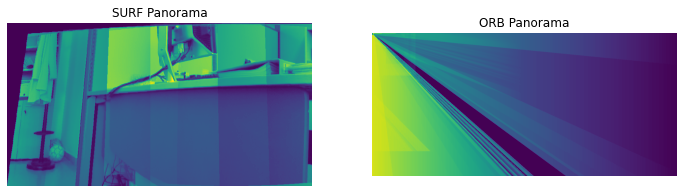

Group 1 - SURF -> PSNR: 27.88, SSIM: 0.3921
Group 1 - ORB -> PSNR: 27.89, SSIM: 0.3074
Processing Panaromic_Dataset\p2 with SURF...
Found 16 images.
Stitching images 1 and 2 using SURF...
Stitching images 3 and 4 using SURF...
Stitching images 5 and 6 using SURF...
Stitching images 7 and 8 using SURF...
Stitching images 9 and 10 using SURF...
Skipping stitching due to insufficient or invalid homography matrix.
Stitching images 11 and 12 using SURF...
Stitching images 13 and 14 using SURF...
Stitching images 15 and 16 using SURF...
Stitching images 1 and 2 using SURF...
Stitching images 3 and 4 using SURF...
Skipping stitching due to insufficient or invalid homography matrix.
Stitching images 5 and 6 using SURF...
Skipping stitching due to insufficient or invalid homography matrix.
Stitching images 7 and 8 using SURF...
Stitching images 1 and 2 using SURF...
Skipping stitching due to insufficient or invalid homography matrix.
Stitching images 3 and 4 using SURF...
Skipping stitching due

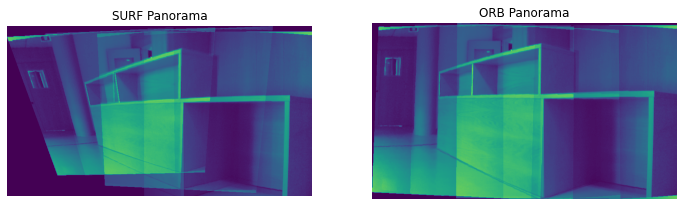

Group 2 - SURF -> PSNR: 27.92, SSIM: 0.4057
Group 2 - ORB -> PSNR: 27.98, SSIM: 0.4803
Processing Panaromic_Dataset\p3 with SURF...
Found 16 images.
Stitching images 1 and 2 using SURF...
Stitching images 3 and 4 using SURF...
Stitching images 5 and 6 using SURF...
Stitching images 7 and 8 using SURF...
Skipping stitching due to insufficient or invalid homography matrix.
Stitching images 9 and 10 using SURF...
Skipping stitching due to insufficient or invalid homography matrix.
Stitching images 11 and 12 using SURF...
Skipping stitching due to insufficient or invalid homography matrix.
Stitching images 13 and 14 using SURF...
Stitching images 15 and 16 using SURF...
Stitching images 1 and 2 using SURF...
Stitching images 3 and 4 using SURF...
Skipping stitching due to insufficient or invalid homography matrix.
Stitching images 5 and 6 using SURF...
Skipping stitching due to insufficient or invalid homography matrix.
Stitching images 7 and 8 using SURF...
Stitching images 1 and 2 using 

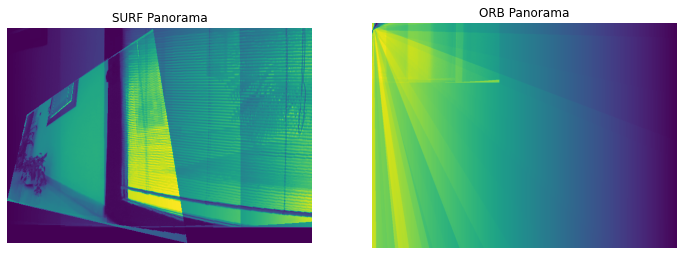

Group 3 - SURF -> PSNR: 28.07, SSIM: 0.2487
Group 3 - ORB -> PSNR: 27.82, SSIM: 0.4038
Processing Panaromic_Dataset\p4 with SURF...
Found 16 images.
Stitching images 1 and 2 using SURF...
Stitching images 3 and 4 using SURF...
Stitching images 5 and 6 using SURF...
Stitching images 7 and 8 using SURF...
Stitching images 9 and 10 using SURF...


C:\Users\ilbey\anaconda3\envs\py36_env\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\ilbey\anaconda3\envs\py36_env\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


Stitching images 11 and 12 using SURF...
Stitching images 13 and 14 using SURF...
Stitching images 15 and 16 using SURF...
Stitching images 1 and 2 using SURF...
Stitching images 3 and 4 using SURF...
Stitching images 5 and 6 using SURF...
Skipping stitching due to insufficient or invalid homography matrix.
Stitching images 7 and 8 using SURF...
Skipping stitching due to insufficient or invalid homography matrix.
Stitching images 1 and 2 using SURF...
Stitching images 3 and 4 using SURF...
Skipping stitching due to insufficient or invalid homography matrix.
Stitching images 1 and 2 using SURF...
Skipping stitching due to insufficient or invalid homography matrix.
Processing Panaromic_Dataset\p4 with ORB...
Found 16 images.
Stitching images 1 and 2 using ORB...
Stitching images 3 and 4 using ORB...
Stitching images 5 and 6 using ORB...
Stitching images 7 and 8 using ORB...
Stitching images 9 and 10 using ORB...
Stitching images 11 and 12 using ORB...
Stitching images 13 and 14 using ORB

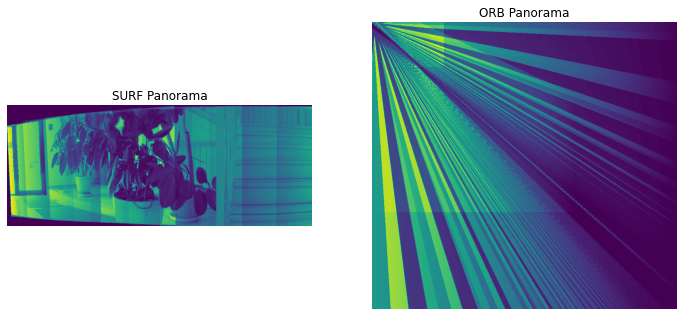

Group 4 - SURF -> PSNR: 28.27, SSIM: 0.3631
Group 4 - ORB -> PSNR: 27.88, SSIM: 0.1538
Processing Panaromic_Dataset\p5 with SURF...
Found 16 images.
Stitching images 1 and 2 using SURF...
Stitching images 3 and 4 using SURF...
Skipping stitching due to insufficient or invalid homography matrix.
Stitching images 5 and 6 using SURF...
Skipping stitching due to insufficient or invalid homography matrix.
Stitching images 7 and 8 using SURF...
Skipping stitching due to insufficient or invalid homography matrix.
Stitching images 9 and 10 using SURF...
Stitching images 11 and 12 using SURF...
Stitching images 13 and 14 using SURF...
Stitching images 15 and 16 using SURF...
Stitching images 1 and 2 using SURF...
Stitching images 3 and 4 using SURF...
Skipping stitching due to insufficient or invalid homography matrix.
Stitching images 5 and 6 using SURF...
Skipping stitching due to insufficient or invalid homography matrix.
Stitching images 7 and 8 using SURF...
Stitching images 1 and 2 using 

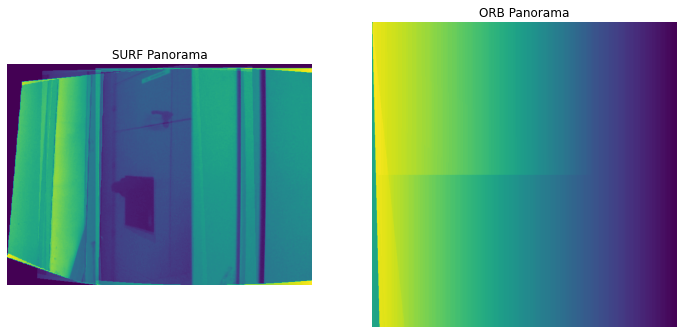

Group 5 - SURF -> PSNR: 28.41, SSIM: 0.5771
Group 5 - ORB -> PSNR: 27.85, SSIM: 0.5922
Processing Panaromic_Dataset\p6 with SURF...
Found 16 images.
Stitching images 1 and 2 using SURF...
Stitching images 3 and 4 using SURF...
Stitching images 5 and 6 using SURF...
Stitching images 7 and 8 using SURF...
Stitching images 9 and 10 using SURF...
Stitching images 11 and 12 using SURF...
Stitching images 13 and 14 using SURF...
Stitching images 15 and 16 using SURF...
Stitching images 1 and 2 using SURF...
Stitching images 3 and 4 using SURF...
Stitching images 5 and 6 using SURF...
Stitching images 7 and 8 using SURF...
Stitching images 1 and 2 using SURF...
Stitching images 3 and 4 using SURF...
Stitching images 1 and 2 using SURF...
Processing Panaromic_Dataset\p6 with ORB...
Found 16 images.
Stitching images 1 and 2 using ORB...
Stitching images 3 and 4 using ORB...
Stitching images 5 and 6 using ORB...
Stitching images 7 and 8 using ORB...
Stitching images 9 and 10 using ORB...
Stitchi

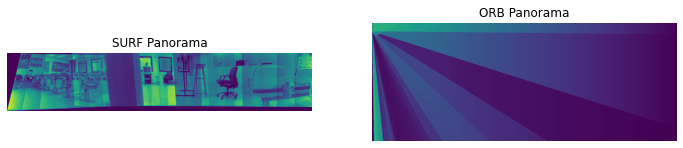

Group 6 - SURF -> PSNR: 27.74, SSIM: 0.3740
Group 6 - ORB -> PSNR: 28.11, SSIM: 0.2589
Processing Panaromic_Dataset\p7 with SURF...
Found 16 images.
Stitching images 1 and 2 using SURF...
Stitching images 3 and 4 using SURF...
Stitching images 5 and 6 using SURF...
Stitching images 7 and 8 using SURF...
Stitching images 9 and 10 using SURF...
Stitching images 11 and 12 using SURF...
Stitching images 13 and 14 using SURF...
Stitching images 15 and 16 using SURF...
Stitching images 1 and 2 using SURF...
Stitching images 3 and 4 using SURF...
Stitching images 5 and 6 using SURF...
Stitching images 7 and 8 using SURF...
Stitching images 1 and 2 using SURF...
Stitching images 3 and 4 using SURF...
Skipping stitching due to insufficient or invalid homography matrix.
Stitching images 1 and 2 using SURF...
Skipping stitching due to insufficient or invalid homography matrix.
Processing Panaromic_Dataset\p7 with ORB...
Found 16 images.
Stitching images 1 and 2 using ORB...
Stitching images 3 and

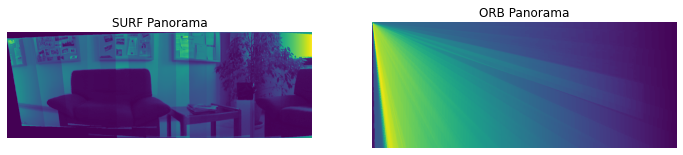

Group 7 - SURF -> PSNR: 28.17, SSIM: 0.3243
Group 7 - ORB -> PSNR: 27.82, SSIM: 0.3720
Processing Panaromic_Dataset\p8 with SURF...
Found 16 images.
Stitching images 1 and 2 using SURF...
Stitching images 3 and 4 using SURF...
Stitching images 5 and 6 using SURF...
Stitching images 7 and 8 using SURF...
Stitching images 9 and 10 using SURF...
Stitching images 11 and 12 using SURF...
Stitching images 13 and 14 using SURF...
Stitching images 15 and 16 using SURF...
Stitching images 1 and 2 using SURF...
Stitching images 3 and 4 using SURF...
Skipping stitching due to insufficient or invalid homography matrix.
Stitching images 5 and 6 using SURF...
Stitching images 7 and 8 using SURF...
Stitching images 1 and 2 using SURF...
Stitching images 3 and 4 using SURF...
Stitching images 1 and 2 using SURF...
Skipping stitching due to insufficient or invalid homography matrix.
Processing Panaromic_Dataset\p8 with ORB...
Found 16 images.
Stitching images 1 and 2 using ORB...
Stitching images 3 and

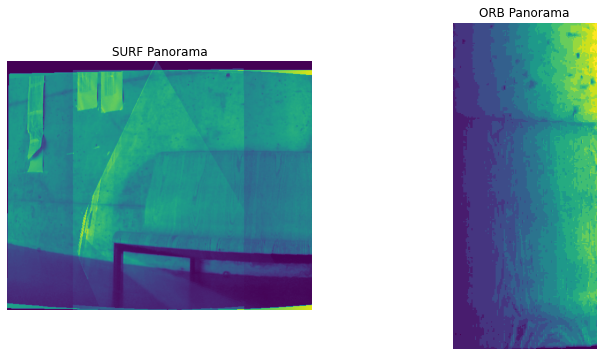

Group 8 - SURF -> PSNR: 28.42, SSIM: 0.4775
Group 8 - ORB -> PSNR: 28.16, SSIM: 0.1304
Processing Panaromic_Dataset\p9 with SURF...
Found 16 images.
Stitching images 1 and 2 using SURF...
Stitching images 3 and 4 using SURF...
Stitching images 5 and 6 using SURF...
Stitching images 7 and 8 using SURF...
Stitching images 9 and 10 using SURF...
Stitching images 11 and 12 using SURF...
Stitching images 13 and 14 using SURF...
Stitching images 15 and 16 using SURF...
Stitching images 1 and 2 using SURF...
Stitching images 3 and 4 using SURF...
Skipping stitching due to insufficient or invalid homography matrix.
Stitching images 5 and 6 using SURF...
Stitching images 7 and 8 using SURF...
Stitching images 1 and 2 using SURF...
Stitching images 3 and 4 using SURF...
Stitching images 1 and 2 using SURF...
Skipping stitching due to insufficient or invalid homography matrix.
Processing Panaromic_Dataset\p9 with ORB...
Found 16 images.
Stitching images 1 and 2 using ORB...
Stitching images 3 and

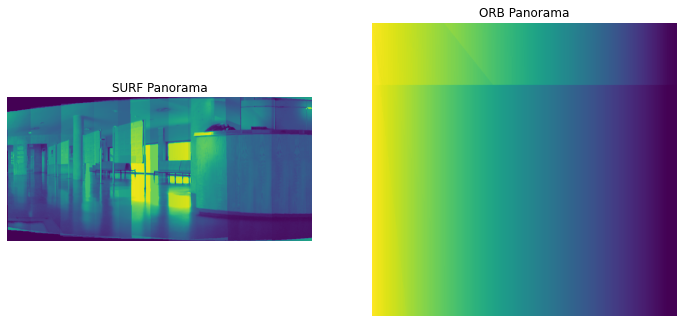

Group 9 - SURF -> PSNR: 27.92, SSIM: 0.4104
Group 9 - ORB -> PSNR: 27.86, SSIM: 0.4785


In [8]:
input_dirs = ['Panaromic_Dataset\\p1', 'Panaromic_Dataset\\p2', 'Panaromic_Dataset\\p3',
              'Panaromic_Dataset\\p4', 'Panaromic_Dataset\\p5', 'Panaromic_Dataset\\p6',
              'Panaromic_Dataset\\p7', 'Panaromic_Dataset\\p8', 'Panaromic_Dataset\\p9']

comparison_results = {}

# Example loop to process images using SURF instead of SIFT
for i, input_dir in enumerate(input_dirs, 1):
    # Generate panoramas with SURF and ORB
    surf_panorama = make_panorama(input_dir, method='SURF', display_matches=False)
    orb_panorama = make_panorama(input_dir, method='ORB', display_matches=False)
    
    # Convert panoramas to grayscale
    surf_gray = cv2.cvtColor(surf_panorama, cv2.COLOR_BGR2GRAY)
    orb_gray = cv2.cvtColor(orb_panorama, cv2.COLOR_BGR2GRAY)
    
    # Display panoramas side by side
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(surf_gray)
    plt.title("SURF Panorama")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(orb_gray)
    plt.title("ORB Panorama")
    plt.axis('off')
    
    plt.show()

    # Load ground truth image
    gt_folder = 'Panaromic_Dataset\\ground_truths'
    ground_truth = cv2.imread(os.path.join(gt_folder, f"pano{i}_gt.png"), cv2.IMREAD_GRAYSCALE)
    if ground_truth is None:
        print(f"No ground truth image found for group {i}")
        continue
    
    # Resize panoramas to match ground truth
    surf_resized = cv2.resize(surf_gray, (ground_truth.shape[1], ground_truth.shape[0]))
    orb_resized = cv2.resize(orb_gray, (ground_truth.shape[1], ground_truth.shape[0]))

    # Calculate PSNR and SSIM
    surf_psnr = calculate_psnr(surf_resized, ground_truth)
    surf_ssim = calculate_ssim(surf_resized, ground_truth)
    orb_psnr = calculate_psnr(orb_resized, ground_truth)
    orb_ssim = calculate_ssim(orb_resized, ground_truth)

    # Store results
    comparison_results[i] = {
        "SURF_PSNR": surf_psnr,
        "SURF_SSIM": surf_ssim,
        "ORB_PSNR": orb_psnr,
        "ORB_SSIM": orb_ssim
    }

    print(f"Group {i} - SURF -> PSNR: {surf_psnr:.2f}, SSIM: {surf_ssim:.4f}")
    print(f"Group {i} - ORB -> PSNR: {orb_psnr:.2f}, SSIM: {orb_ssim:.4f}")

results_df = pd.DataFrame.from_dict(comparison_results, orient="index")

# Scroll down to see full output